In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

In [2]:
train = pd.read_parquet('data/train.parquet.gzip')                     # тренировочный датасет
items_meta = pd.read_parquet(f'data/items_meta.parquet.gzip')          # авторы постов и эмбеддинги содержимого
candidates_df = pd.read_parquet(f'data/fresh_candidates.parquet.gzip') # появившиеся недавно посты
test = pd.read_parquet('data/test.parquet.gzip')                       # список пользователей, для которых 
                                                                       # нужно сформировать рекомендации

In [3]:
train.head(4)

,user_id,item_id,timespent,reaction
0,707536,67950,0,0
1,707536,151002,0,0
2,707536,134736,0,0
3,707536,196151,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144440015 entries, 0 to 144440014
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   user_id    int32
 1   item_id    int32
 2   timespent  int8 
 3   reaction   int8 
dtypes: int32(2), int8(2)
memory usage: 1.3 GB


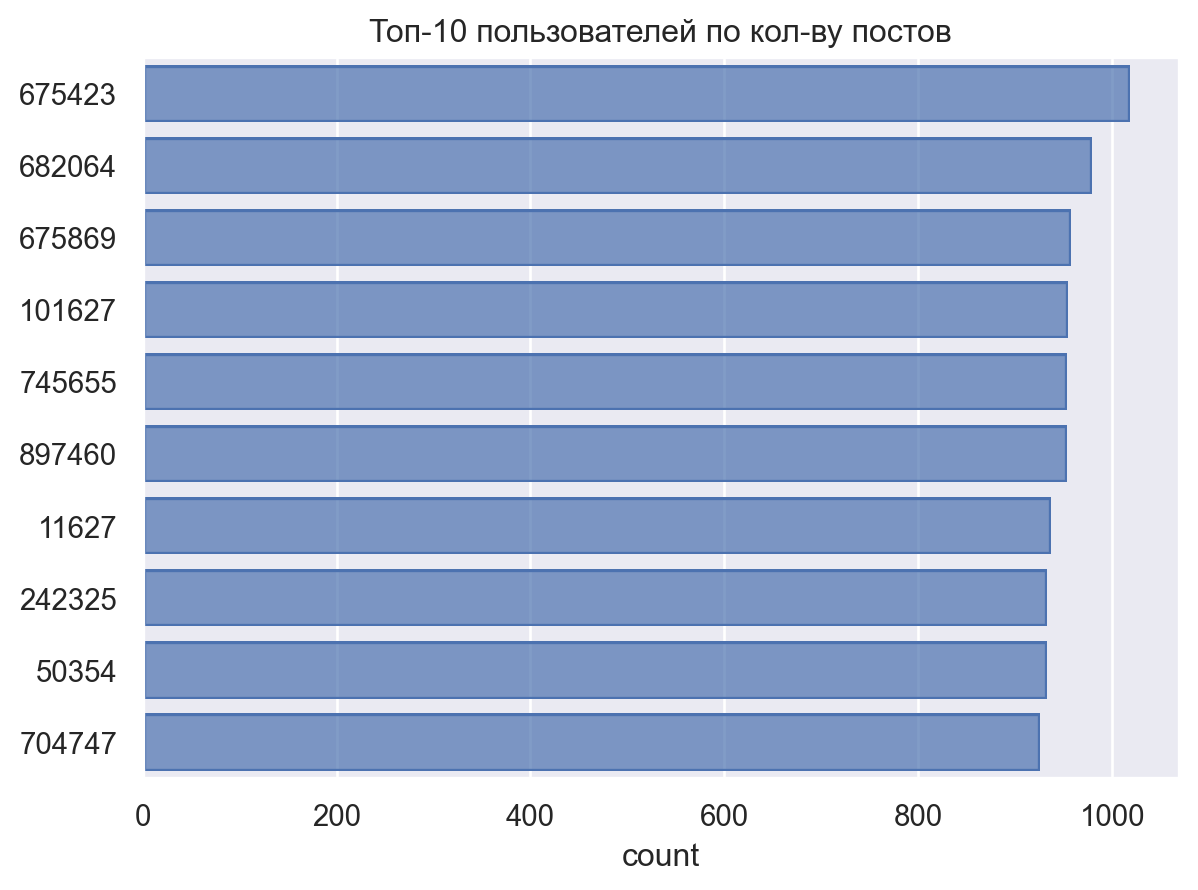

In [5]:
g = train.user_id.value_counts() # всего 1 000 183 пользователей

p = so.Plot(g.head(10), g.head(10).index.astype(str)).add(so.Bar())
p.label(title='Топ-10 пользователей по кол-ву постов', x='count', y='')

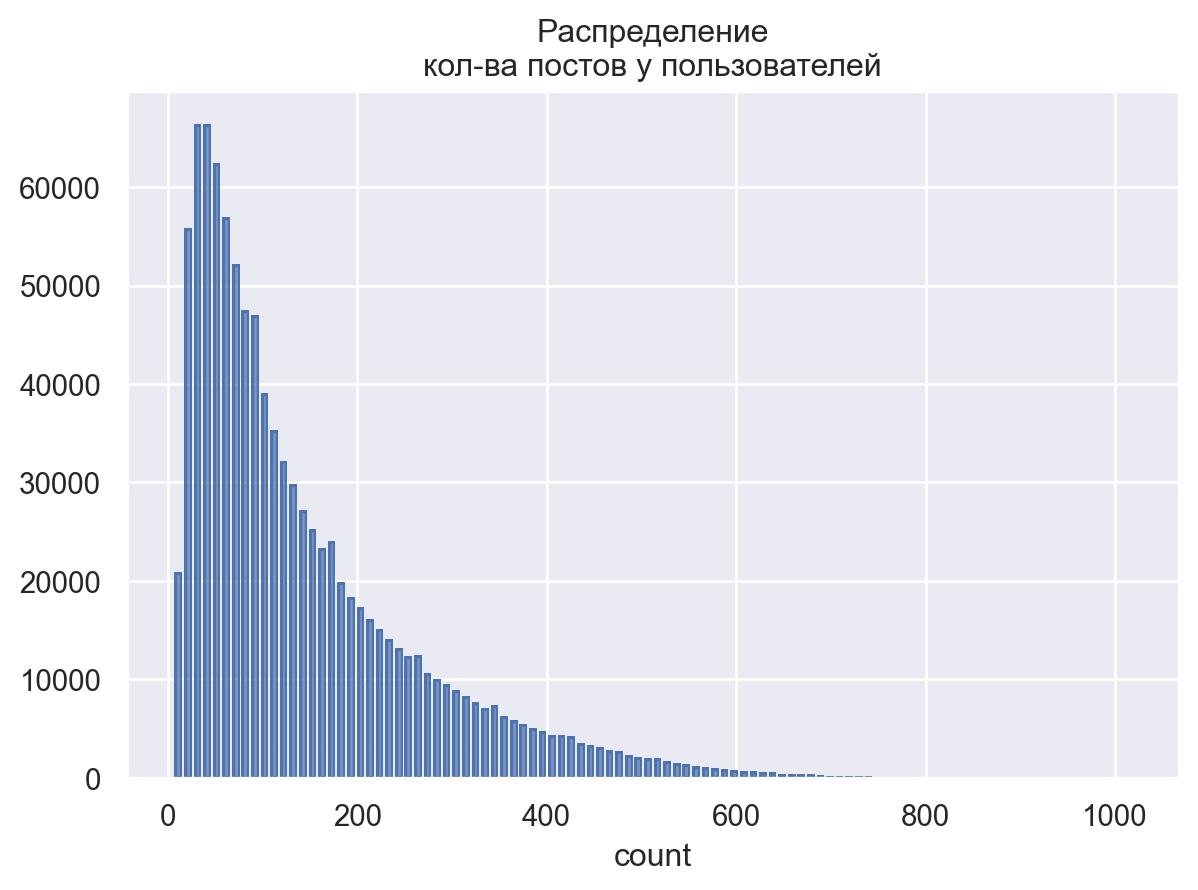

In [6]:
p = so.Plot(g).add(so.Bar(), so.Hist(bins=100))
p.label(title='Pаспределение\nкол-ва постов у пользователей', x='count', y='')

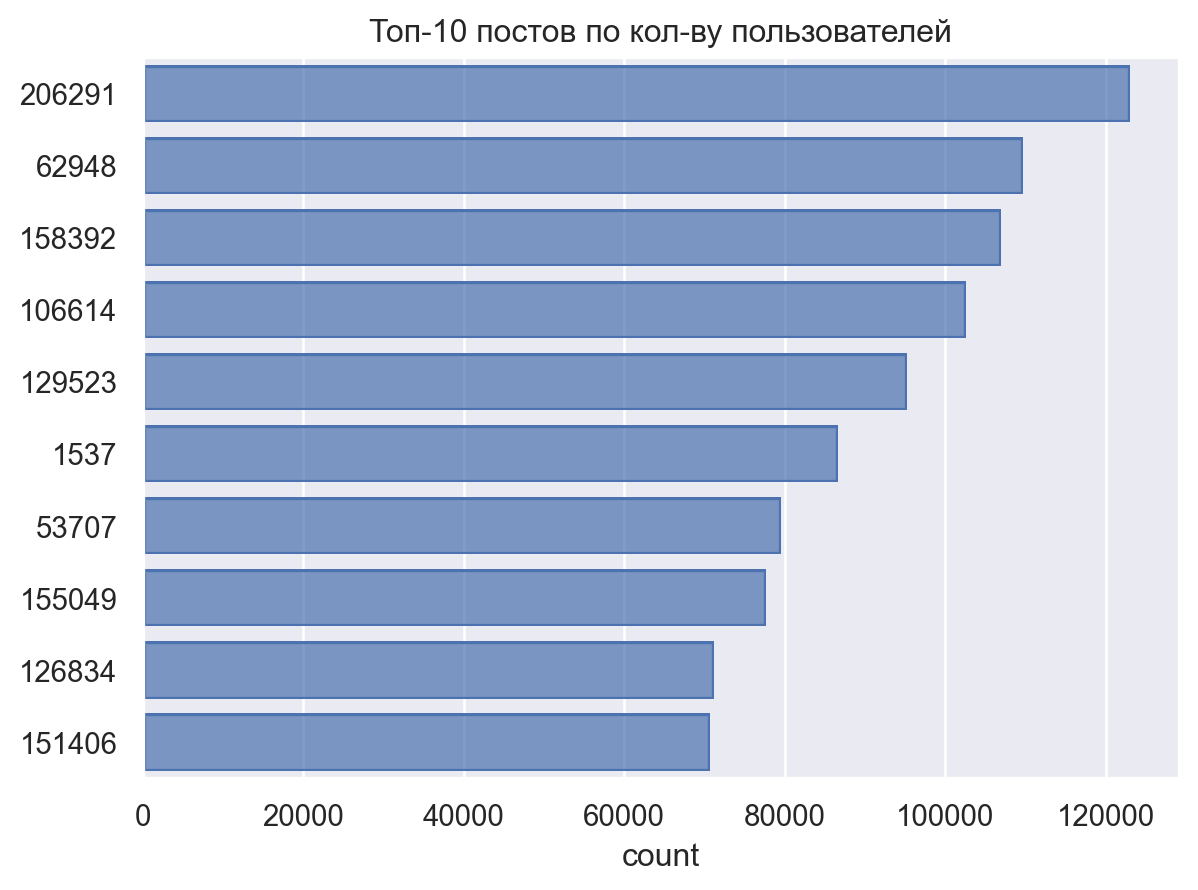

In [7]:
g = train.item_id.value_counts() # Всего 227 606 постов

p = so.Plot(g.head(10), g.head(10).index.astype(str)).add(so.Bar())
p.label(title='Топ-10 постов по кол-ву пользователей', x='count', y='')

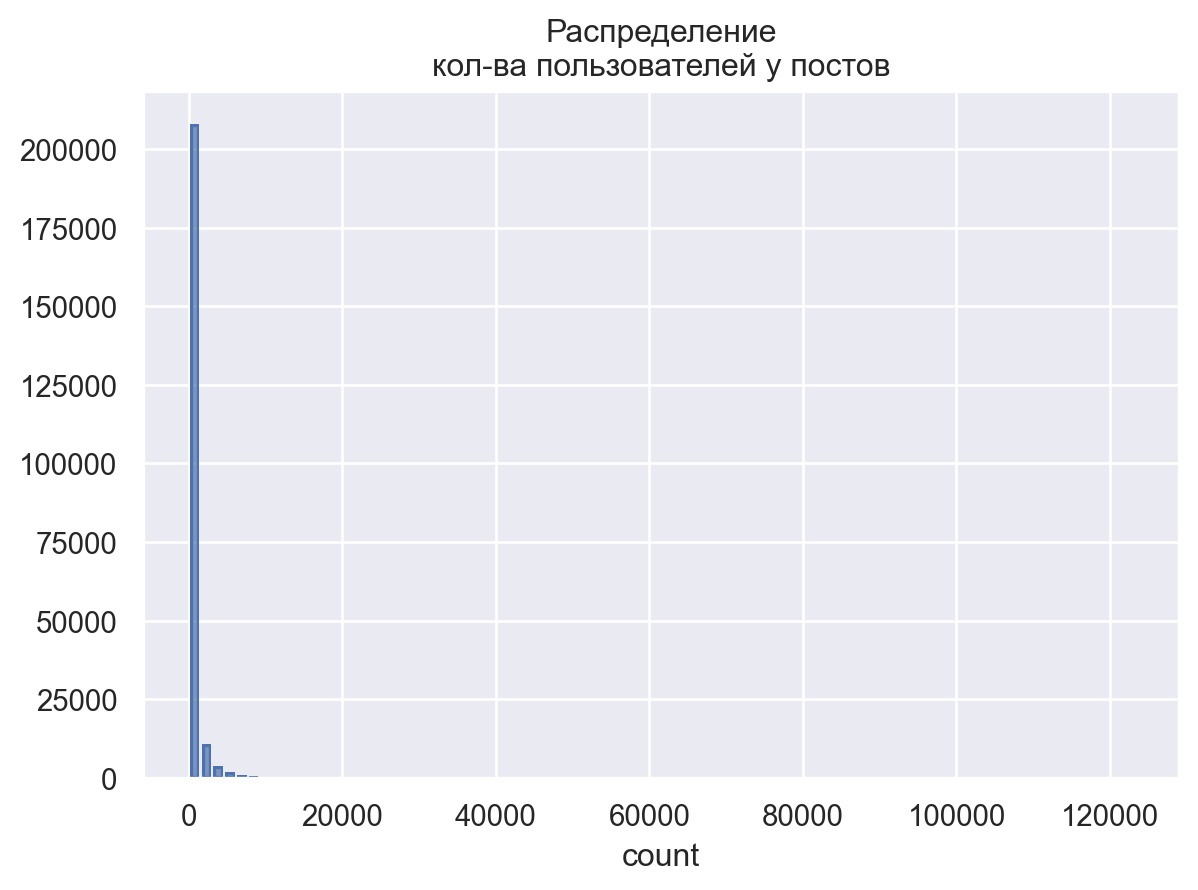

In [8]:
p = so.Plot(g).add(so.Bar(), so.Hist(bins=80))
p.label(title='Распределение\nкол-ва пользователей у постов', x='count', y='')

In [9]:
g = train.groupby('item_id').agg({'timespent':'mean'}).sort_values(by='timespent', ascending=False)

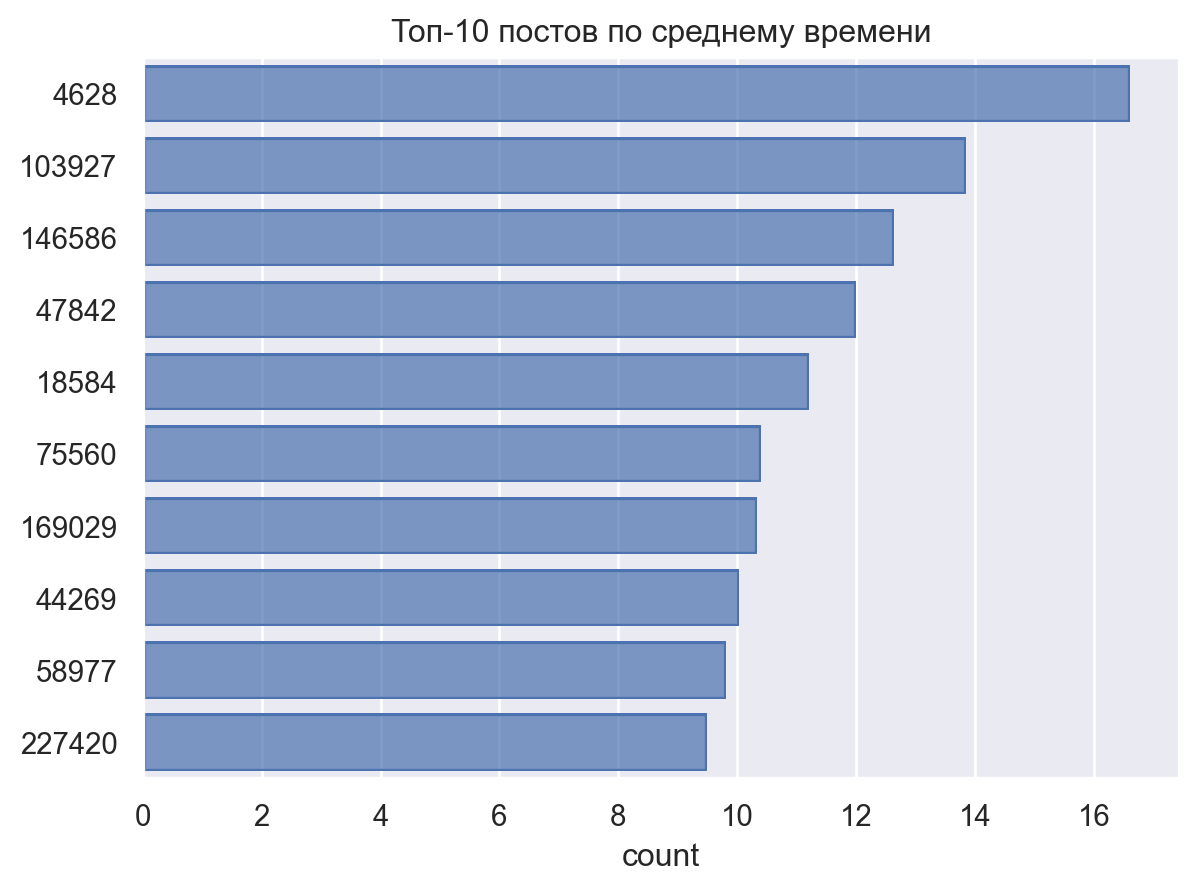

In [10]:
p = so.Plot(g.timespent.head(10), g.head(10).index.astype(str)).add(so.Bar())
p.label(title='Топ-10 постов по среднему времени', x='count', y='')

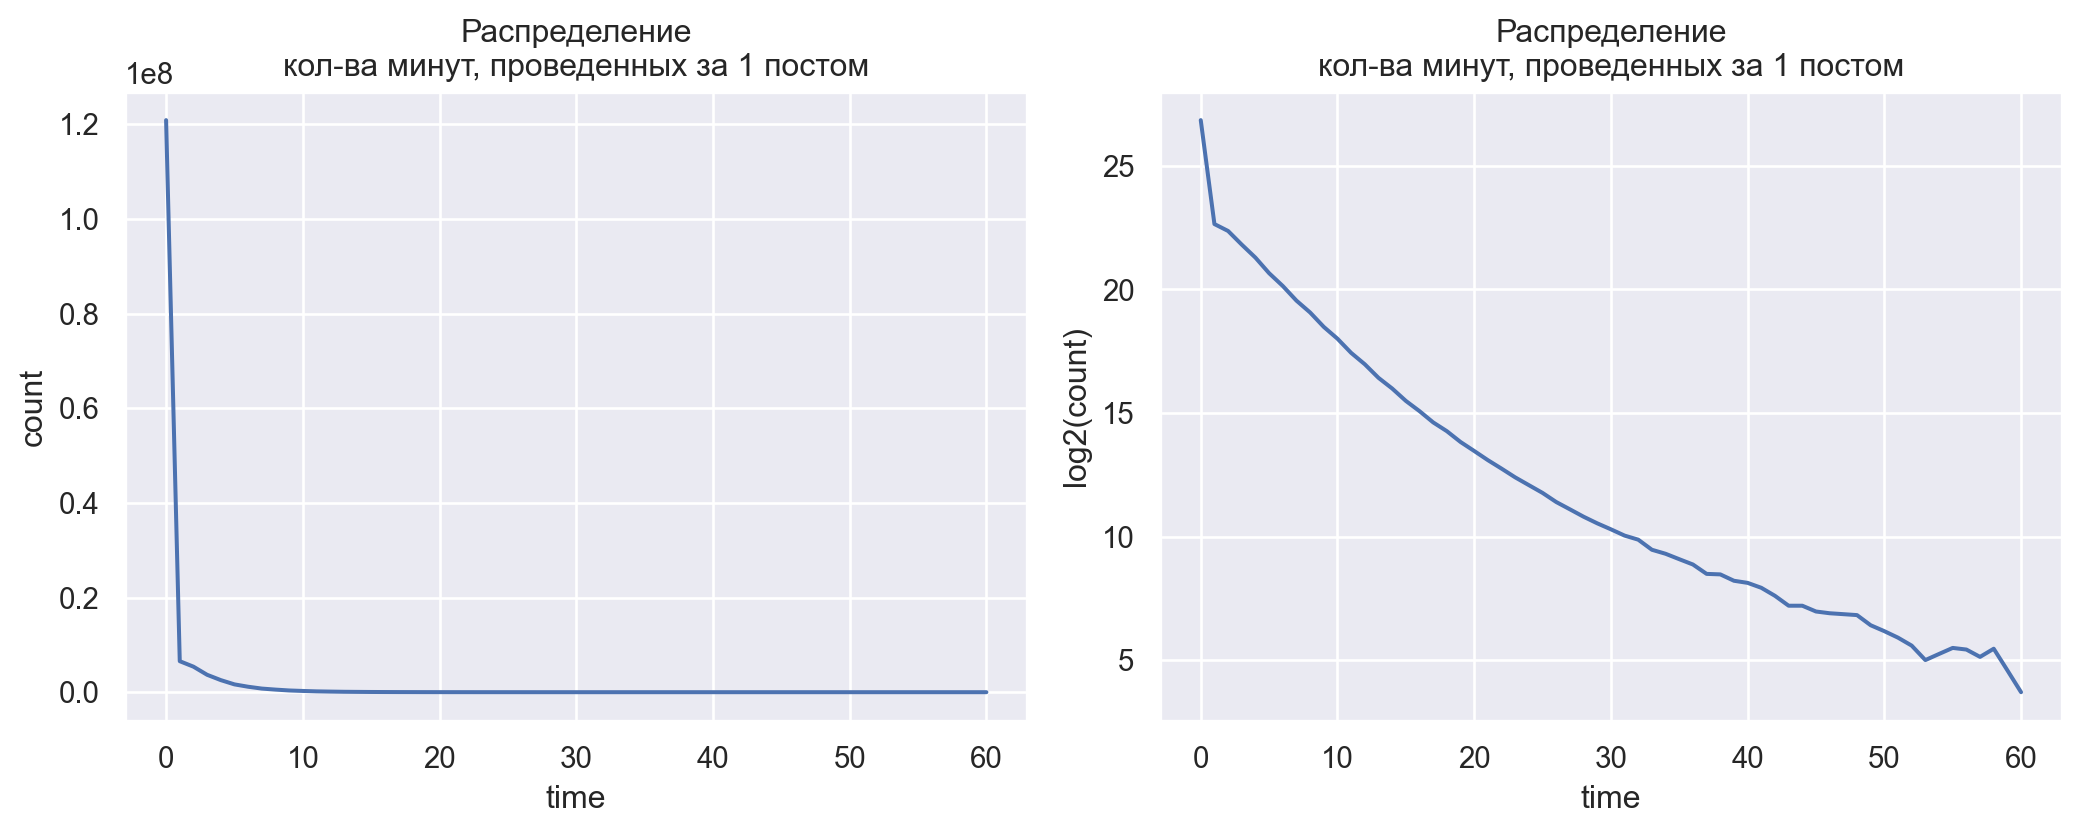

In [11]:
g = train.timespent.value_counts() # в среднем - 0.54466, median - 0

(
    so.Plot(x=g.index)
    .layout(size=(11, 4.5))
    .pair(y=[g, np.log2(g)], wrap=1)
    .label(title='Распределение\nкол-ва минут, проведенных за 1 постом', x='time', y0='count', y1='log2(count)')
    .add(so.Line())
)

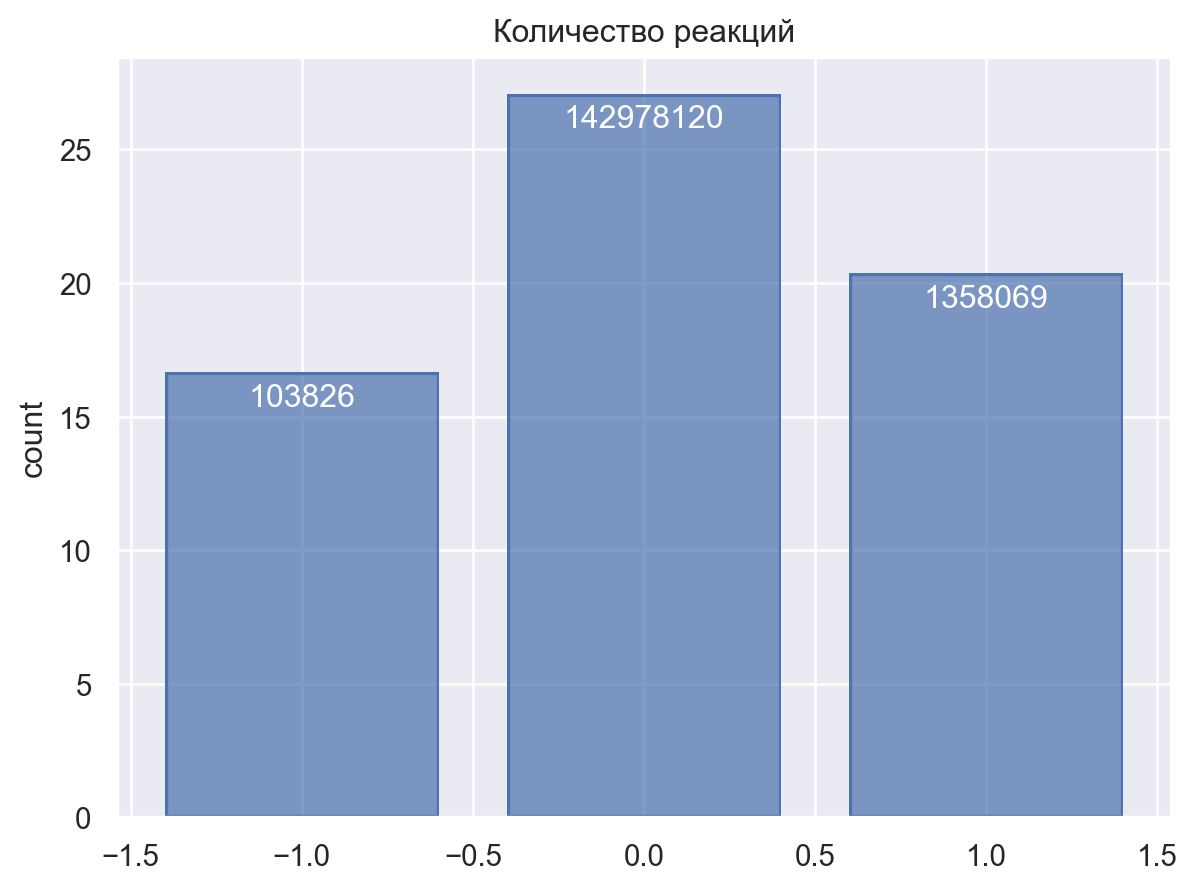

In [12]:
g = train.reaction.value_counts() # в среднем - 0.54466, median - 0

p = (
    so.Plot(x=g.index, y=np.log2(g), text=g)
    .add(so.Bar())
    .add(so.Text(color="w",valign="top"))
)
p.label(title='Количество реакций', x='', y='count')

In [13]:
items_meta.head()

,item_id,source_id,embeddings
0,0,7340,"[0.10458118, 0.047880154, 0.030944156, -0.0351..."
1,1,6284,"[0.035625108, -0.039264094, -0.03310334, -0.04..."
2,2,12766,"[0.08418761, 0.006732465, -0.0037112322, -0.02..."
3,3,14734,"[0.049901545, 0.039079394, -0.03890682, -0.053..."
4,4,22557,"[0.09303163, 0.023448057, 0.0029488814, -0.017..."


In [14]:
items_meta_orig = items_meta.copy()

In [26]:
items_meta = items_meta_orig.copy()

In [27]:
items_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227606 entries, 0 to 227605
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   item_id     227606 non-null  int32 
 1   source_id   227606 non-null  int32 
 2   embeddings  227606 non-null  object
dtypes: int32(2), object(1)
memory usage: 3.5+ MB


In [28]:
items_meta.embeddings.apply(lambda x: x.shape).unique() # all embeddings have size - 312

array([(312,)], dtype=object)

In [29]:
items_meta.source_id.unique().size

24438

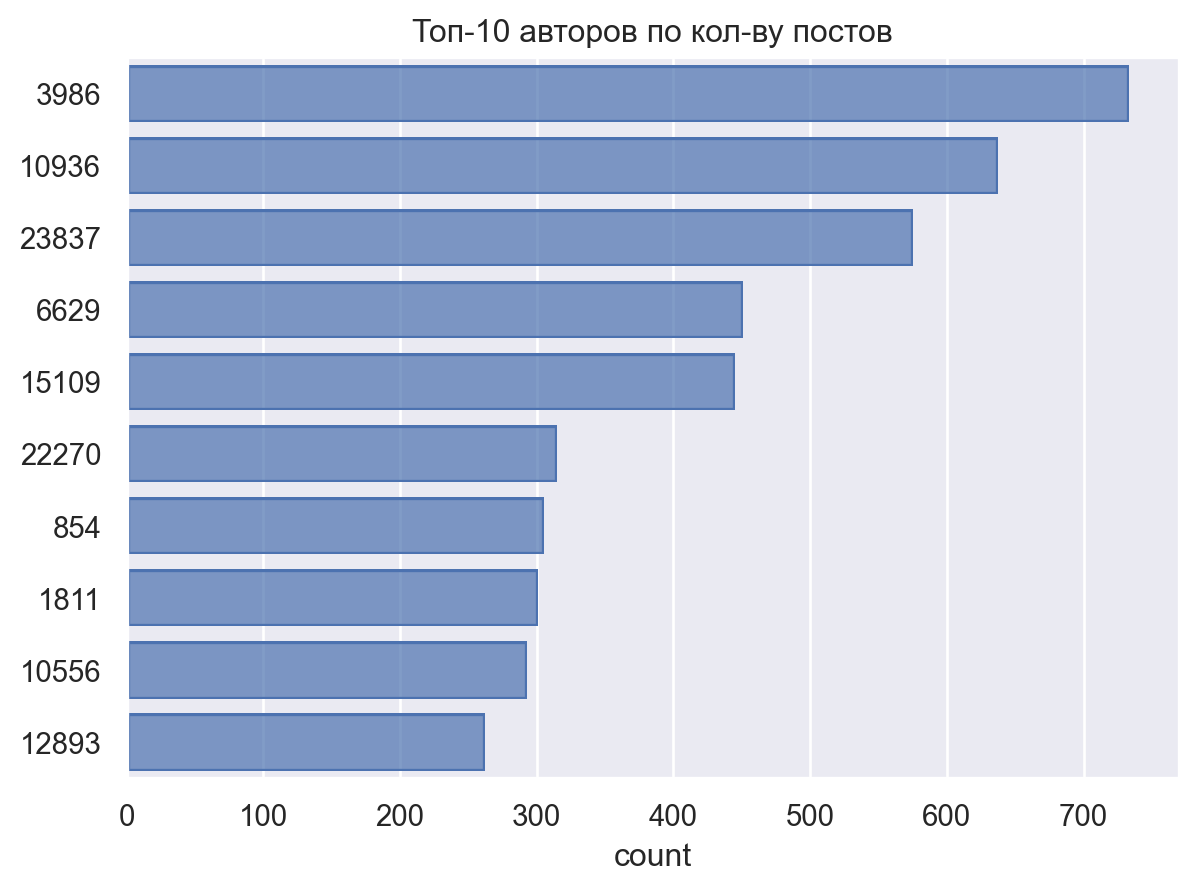

In [30]:
g = items_meta.source_id.value_counts() # Всего 24 438 авторов

p = so.Plot(g.head(10), g.head(10).index.astype(str)).add(so.Bar())
p.label(title='Топ-10 авторов по кол-ву постов', x='count', y='')

In [31]:
items_meta['time_mean'] = train.groupby('item_id').agg({'timespent':'mean'}).timespent
items_meta['time_std'] = train.groupby('item_id').agg({'timespent':'std'}).timespent
items_meta['views'] = train.groupby('item_id').agg({'timespent':'count'}).timespent

In [32]:
likes = train.loc[train.reaction>0].groupby('item_id').agg({'reaction':'count'}).reset_index()
likes.columns = ['item_id', 'likes']

dislikes = train.loc[train.reaction<0].groupby('item_id').agg({'reaction':'count'}).reset_index()
dislikes.columns = ['item_id', 'dislikes']

items_meta = items_meta.merge(likes, on='item_id', how='left')
items_meta.likes = items_meta.likes.fillna(0).astype('int')

items_meta = items_meta.merge(dislikes, on='item_id', how='left')
items_meta.dislikes = items_meta.dislikes.fillna(0).astype('int')

In [45]:
items_meta.sort_values(by='item_id', ascending=True)

,item_id,source_id,embeddings,time_mean,time_std,views,likes,dislikes
0,0,7340,"[0.10458118, 0.047880154, 0.030944156, -0.0351...",0.666667,1.175139,15,2,0
1,1,6284,"[0.035625108, -0.039264094, -0.03310334, -0.04...",0.398168,1.516723,1419,4,0
2,2,12766,"[0.08418761, 0.006732465, -0.0037112322, -0.02...",1.578616,2.840448,159,13,0
3,3,14734,"[0.049901545, 0.039079394, -0.03890682, -0.053...",0.300000,0.754318,230,0,0
4,4,22557,"[0.09303163, 0.023448057, 0.0029488814, -0.017...",0.214350,0.643829,1115,1,0
...,...,...,...,...,...,...,...,...
227601,227601,19043,"[0.06742832, -0.08209568, -0.04407321, 0.00838...",0.183784,1.112555,185,3,1
227602,227602,9384,"[0.07055114, -0.007334651, -0.0032477665, 0.00...",0.125000,0.464531,96,1,0
227603,227603,24152,"[0.13771634, 0.023559753, 0.012204557, -0.0361...",0.160000,0.374166,25,2,0
227604,227604,20249,"[0.04954276, -0.00674311, -0.040121585, -0.024...",0.379310,1.115277,29,0,0


In [171]:
user_items = train.loc[train.user_id==675423].sort_values(by='timespent', ascending=False)

In [176]:
df = items_meta.merge(user_items, on='item_id').sort_values(by='reaction', ascending=False)

In [192]:
user_embeddings = pd.DataFrame(embeddings[df.item_id.values])

In [180]:
X = df.drop(['item_id', 'embeddings', 'user_id', 'timespent', 'reaction'], axis=1)

In [181]:
y = df.timespent

In [183]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
# embeddings[135023]

In [107]:
from scipy.stats import pearsonr

In [152]:
d = {
    'item_id': [],
    'correlation': [],
    'p_value': [],
}

for i in range(embeddings.shape[0]):
    if i not in user_items.item_id.values:
        corr = pearsonr(embeddings[87349], embeddings[i])
        d['item_id'].append(i)
        d['correlation'].append(corr[0])
        d['p_value'].append(corr[1])

In [154]:
ids = np.array(d['correlation']).argmax()
print('item_id:     ', ids)
print('correlation: ', d['correlation'][ids])
print('p-value:     ', d['p_value'][ids])

item_id:      88799
correlation:  0.9309382072666021
p-value:      1.155417318383524e-137


In [150]:
items_meta.loc[items_meta.item_id==135023]

,item_id,source_id,embeddings,time_mean,time_std,views,likes,dislikes
135023,135023,11233,"[0.054317195, -0.02809662, -0.069919385, -0.01...",0.917484,2.007613,3672,3,0


In [156]:
items_meta.loc[items_meta.item_id==87349]

,item_id,source_id,embeddings,time_mean,time_std,views,likes,dislikes
87349,87349,22749,"[0.0048154946, 0.0049653426, -0.008080961, -0....",0.98995,2.380445,7065,18,4


In [155]:
items_meta.loc[items_meta.item_id==88799]

,item_id,source_id,embeddings,time_mean,time_std,views,likes,dislikes
88799,88799,5105,"[0.0055441647, -0.045775577, 0.013770939, -0.0...",0.227088,1.018864,982,2,0


In [157]:
items_meta

,item_id,source_id,embeddings,time_mean,time_std,views,likes,dislikes
0,0,7340,"[0.10458118, 0.047880154, 0.030944156, -0.0351...",0.666667,1.175139,15,2,0
1,1,6284,"[0.035625108, -0.039264094, -0.03310334, -0.04...",0.398168,1.516723,1419,4,0
2,2,12766,"[0.08418761, 0.006732465, -0.0037112322, -0.02...",1.578616,2.840448,159,13,0
3,3,14734,"[0.049901545, 0.039079394, -0.03890682, -0.053...",0.300000,0.754318,230,0,0
4,4,22557,"[0.09303163, 0.023448057, 0.0029488814, -0.017...",0.214350,0.643829,1115,1,0
...,...,...,...,...,...,...,...,...
227601,227601,19043,"[0.06742832, -0.08209568, -0.04407321, 0.00838...",0.183784,1.112555,185,3,1
227602,227602,9384,"[0.07055114, -0.007334651, -0.0032477665, 0.00...",0.125000,0.464531,96,1,0
227603,227603,24152,"[0.13771634, 0.023559753, 0.012204557, -0.0361...",0.160000,0.374166,25,2,0
227604,227604,20249,"[0.04954276, -0.00674311, -0.040121585, -0.024...",0.379310,1.115277,29,0,0
